In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from itertools import zip_longest
from sklearn.utils import shuffle
import random
np.set_printoptions(suppress=True)

In [2]:
SEED = 8
random.seed(SEED)
def shuffle_forward(l):
    order = list(range(len(l)))
    random.shuffle(order)
    return np.array(np.array(l)[order]), order

def shuffle_backward(l, order):
    l_out = [0] * len(l)
    for i, j in enumerate(order):
        l_out[j] = l[i]
    return l_out

In [3]:
class SingleLayerSNN:
    def __init__(
        self,
        inputs,
        weights,
        trainings,
        Cm=4.0,
        Rm=5.0,
        V_thresh=30.0,
        V_rest=-65.0,
        V_spike=80.0,
        dT=0.01,
        rate=1.0,
    ):
        """
        Runs a LIF simulation on neuron and returns outputted voltage

                Parameters:
                        inputs (double[][][]): A 3d numpy array of the input voltages per timestep
                        weights (double[]): A numpy array of initial weights
                        outputs (double[][][]): A 3d numpy array of the output voltages per timestep used for teaching neuron
                Returns:
                        None
        """

        assert len(trainings) == len(inputs)

        self.inputs = inputs
        self.weights = weights
        self.trainings = trainings
        self.Cm = Cm
        self.Rm = Rm
        self.V_thresh = V_thresh
        self.V_rest = V_rest
        self.V_spike = V_spike
        self.dT = dT  # ms
        self.rate = rate  # sec
        self._LIF_spikes = 0

    def LIF(self, I):
        """
        Runs a LIF simulation on neuron and returns outputted voltage

                Parameters:
                        I (double[]): A numpy array of input voltages in mV

                Returns:
                        V (double[]): A numpy array of the output voltages in mV
        """
        total_time = (I.size) * self.dT

        # an array of time
        time = np.arange(0, total_time, self.dT)

        # default voltage list set to resting volatage of -65mV
        V = (self.V_rest) * np.ones(len(time))

        did_spike = False

        # function member variable to track spikes
        self._LIF_spikes = 0

        for t in range(len(time)):
            # using "I - V(t)/Rm = Cm * dV/dT"
            dV = (I[t] - (V[t - 1] - self.V_rest) / self.Rm) / self.Cm

            # reset membrane potential if neuron spiked last tick
            if did_spike:
                V[t] = self.V_rest + dV * self.dT
            else:
                V[t] = V[t - 1] + dV * self.dT

            # check if membrane voltage exceeded threshold (spike)
            if V[t] > self.V_thresh:
                did_spike = True
                # set the last step to spike value
                V[t] = self.V_spike
                self._LIF_spikes += 1
            else:
                did_spike = False

        return V

    def voltage_to_output(self, V_input):
        """Converts a neuron's internal voltage to output"""
        V_output = np.array([])
        for v in V_input:
            V_output = np.append(V_output, 0 if v < self.V_spike else self.V_spike)
        return V_output

    def voltage_to_spike_rate(self, voltages, dT=None, rate=None):
        """Converts an array of neuron voltages to spikes per n seconds, where n = rate"""
        if not dT:
            dT = self.dT
        if not rate:
            rate = self.rate

        #         print('voltages', voltages)

        def cond(V):
            return V >= self.V_spike

        spike_count = sum(cond(V) for V in voltages)

        #         print('spike_count', spike_count)

        total_time_dT = len(voltages) * dT
        #         print(f'total_time_dT: {total_time_dT} ({dT}ms)')

        spikes_per_dT = spike_count / total_time_dT
        #         print(f'spikes_per_ms: {spikes_per_dT} (spikes/ms)')

        return spikes_per_dT * 1000 * rate

    # returns the voltages of input and output neurons
    def feed_forward(self, inputs, train=True):
        """
        Passes all sets of inputs to 

                Parameters:
                        inputs (double[][][]): A 3d numpy array that contains every set of inputs voltages for each input neuron
                        train (boolean): Determines whether or not to inject training voltages

                Returns:
                        all_input_voltages, all_output_voltages (double[][][], double[][][]): A tuple of all of the input voltages and all of the output voltages
        """
        all_input_voltages = []
        all_output_voltages = []

        # set the training voltages to all zero if not running in training mode
        training_copy = (
            np.zeros(inputs.shape, np.ndarray)
            if not train
            else np.array(self.trainings)
        )
        #         print('training_copy:')
        #         print(training_copy)

        inputs_copy = np.array(inputs)
        #         print('inputs_copy:')
        #         print(inputs_copy)

        assert len(training_copy) == len(inputs_copy)

        zipped = list(zip(inputs_copy, training_copy))

        shuffled, order = shuffle_forward(zipped)
        shuffled_inputs, shuffled_trainings = zip(*shuffled)

        shuffled_inputs = np.array(shuffled_inputs)
        #         print('shuffled_inputs:')
        #         print(shuffled_inputs)

        shuffled_trainings = np.array(shuffled_trainings)
        #         print('shuffled_trainings:')
        #         print(shuffled_trainings)
        
        # feed inputs through inputs to get weighted voltage for output neurons
        for input_set, training_set in zip_longest(shuffled_inputs, shuffled_trainings):
            input_voltages = []
            for V_input in input_set:
                input_voltages.append(self.LIF(V_input))

            output_inputs = []
            input_outputs = []  # DEBUG ONLY
            for weight_set in self.weights.T:
                weighted_sum = np.zeros(len(input_set[0]))
                for V_input, weight in zip(input_voltages, weight_set):
                    # filter for spikes b/c a neuron only outputs if it spikes
                    input_output = self.voltage_to_output(V_input)
                    input_outputs.append(input_output)  # DEBUG ONLY
                    weighted = input_output * weight
                    weighted_sum = np.add(weighted_sum, weighted)

                output_inputs.append(weighted_sum)

            input_voltages = np.array(input_voltages)
            input_outputs = np.array(input_outputs)
            output_inputs = np.array(output_inputs)

            #             print('input_voltages:')
            #             print(input_voltages)
            #             print('input_outputs:')
            #             print(input_outputs)
            #             print('output_inputs:')
            #             print(output_inputs)
            #             print('training_set:')
            #             print(training_set)

            all_input_voltages.append(input_voltages)

            # inject training voltage if in training mode
            assert isinstance(training_set, (list, np.ndarray))
            for i, (output_input, training_input) in enumerate(
                zip(output_inputs, training_set)
            ):
                assert isinstance(training_input, (list, np.ndarray))
                #               padded_training_input = np.pad(training_input, (0, len(output_inputs) - len(training_set)), "constant")
                output_inputs[i] = output_input + training_input

            #             print('output_inputs after injecting training current')
            #             print(output_inputs)

            # run LIF on output neurons
            output_voltages = []
            for V_input in output_inputs:
                output_voltages.append(self.LIF(V_input))

            output_voltages = np.array(output_voltages)
            all_output_voltages.append(output_voltages)

        #             print('output_voltages:')
        #             print(output_voltages)

        # unshuffle the voltages
        all_input_voltages = np.array(shuffle_backward(all_input_voltages, order))
        all_output_voltages = np.array(shuffle_backward(all_output_voltages, order))

        return all_input_voltages, all_output_voltages

    def train(self, epochs=75, a_corr=0.000000002, w_max=2, w_decay=0):
        """Runs feed forward with training dataset"""
        weights_history = []
        for weight_set in self.weights:
            weight_row = []
            for weight in weight_set:
                weight_row.append([weight])
            weights_history.append(weight_row)

        for epoch in range(epochs):
            print(f"Epoch: {epoch + 1}")

            all_input_voltages, all_output_voltages = self.feed_forward(
                self.inputs, train=True
            )

            # debug info
            #             print()
            #             print('------------------------------------------------')
            #             print('all_input_voltages:')
            #             print(all_input_voltages)
            #             print('all_output_voltages:')
            #             print(all_output_voltages)

            #             print('weights:')
            #             print(self.weights)

            # apply learning rule
            for input_voltages, output_voltages in zip(
                all_input_voltages, all_output_voltages
            ):
                #                 print('input_voltages', input_voltages)
                for i, (input_voltage_set, weight_set) in enumerate(
                    zip(input_voltages, self.weights)
                ):
                    #                     print('input_voltage_set', input_voltage_set)
                    input_rate = self.voltage_to_spike_rate(input_voltage_set)
                    #                     print(f'input_rate {i}:', input_rate)

                    for j, (output_voltage_set, weight) in enumerate(
                        zip(output_voltages, weight_set)
                    ):
                        output_rate = self.voltage_to_spike_rate(output_voltage_set)
                        #                         print(f'\toutput_rate {j}:', output_rate)

                        # adjust the weight using Hebb with decay
                        weight_change = a_corr * input_rate * output_rate - w_decay
                        #                         print('\told weight', weight)
                        #                         print('\tweight_change:', weight_change)

                        if weight + weight_change < 0:
                            self.weights[i][j] = 0
                        elif weight + weight_change > w_max:
                            self.weights[i][j] = w_max
                        else:
                            self.weights[i][j] = weight + weight_change

            #                         print('\tnew weight', self.weights[i][j], '\n')

            # update weight history
            for i, weight_set in enumerate(self.weights):
                for j, weight in enumerate(weight_set):
                    weights_history[i][j].append(weight)

        #             print(self.weights)

        # plot neuron spiking data
        #             for i, (input_voltages, output_voltages) in enumerate(zip(all_input_voltages, all_output_voltages)):
        #                 plt.figure(figsize=(20,10))
        #                 plt.title(f'Input: {i + 1}')
        #                 for input_voltage in input_voltages:
        #                     plt.plot(input_voltage, 'b:', alpha=.5)

        #                 for output_voltage in output_voltages:
        #                     plt.plot(output_voltage, 'r--', alpha=.5)

        #             plt.show()

        # plot weights history
        plt.figure(figsize=(20, 10))
        for i, weight_row in enumerate(weights_history):
            for j, weight_history in enumerate(weight_row):
                plt.plot(weight_history, label=f"weight {i}-{j}")
        plt.legend(loc="upper left")
        plt.title("Weight History")
        plt.show()

    def _generate_bar_plot(self, all_bars, ylabel, title, bar_width=0.25):
        '''Generates bar plot for output neuron data'''
        plt.figure(figsize=(20, 10))
        r = np.arange(len(all_bars.T[0]))
        for x, bars in enumerate(all_bars.T):
            plt.bar(r, bars, width=bar_width, label=f"Output Neuron: {x}")
            r = [w + bar_width for w in r]

        plt.xticks([r + bar_width for r in range(len(r))], list(range(len(r))))
        plt.xlabel("Input Neuron")

        plt.ylabel(ylabel)

        plt.legend(loc="upper left")
        plt.title(title)
        plt.show()

    def predict(self, inputs):
        """Runs feed foward without training data on inputs"""
        all_input_voltages, all_output_voltages = self.feed_forward(inputs, train=False)
        #         print('all_output_voltages')
        #         print(all_output_voltages)

        all_output_confidences = []
        all_output_spike_rates = []

        for x, (input_voltages, output_voltages) in enumerate(
            zip(all_input_voltages, all_output_voltages)
        ):
            output_spike_rates = []
            output_confidences = []
            print("input set:", x)
            for i, input_voltage_set in enumerate(input_voltages):
                print(
                    f"\tinput {i}: {self.voltage_to_spike_rate(input_voltage_set)} spikes/{self.rate}s"
                )
            print()

            output_voltages_sum = sum(
                [self.voltage_to_spike_rate(v) for v in output_voltages]
            )
            for i, output_voltage_set in enumerate(output_voltages):
                sr = self.voltage_to_spike_rate(output_voltage_set)
                output_spike_rates.append(sr)
                confidence = (
                    "N/A" if output_voltages_sum == 0 else sr / output_voltages_sum
                )
                output_confidences.append(0 if confidence == "N/A" else confidence)
                print(
                    f"\toutput {i}: {sr} spikes/{self.rate}s, confidence: {confidence}"
                )
            print()
            all_output_spike_rates.append(output_spike_rates)
            all_output_confidences.append(output_confidences)

        all_output_confidences = np.array(all_output_confidences)
        all_output_spike_rates = np.array(all_output_spike_rates)

        #         print(all_output_confidences)
        #         print(all_output_spike_rates)

        # plot output confidence
        self._generate_bar_plot(
            all_output_confidences, ylabel="Confidence", title="Output Confidence"
        )
        # plot output spike rates
        self._generate_bar_plot(
            all_output_spike_rates,
            ylabel=f"Spike Rate (spikes/{self.rate}s)",
            title="Output Spike Rates",
        )
        return all_input_voltages, all_output_voltages


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77


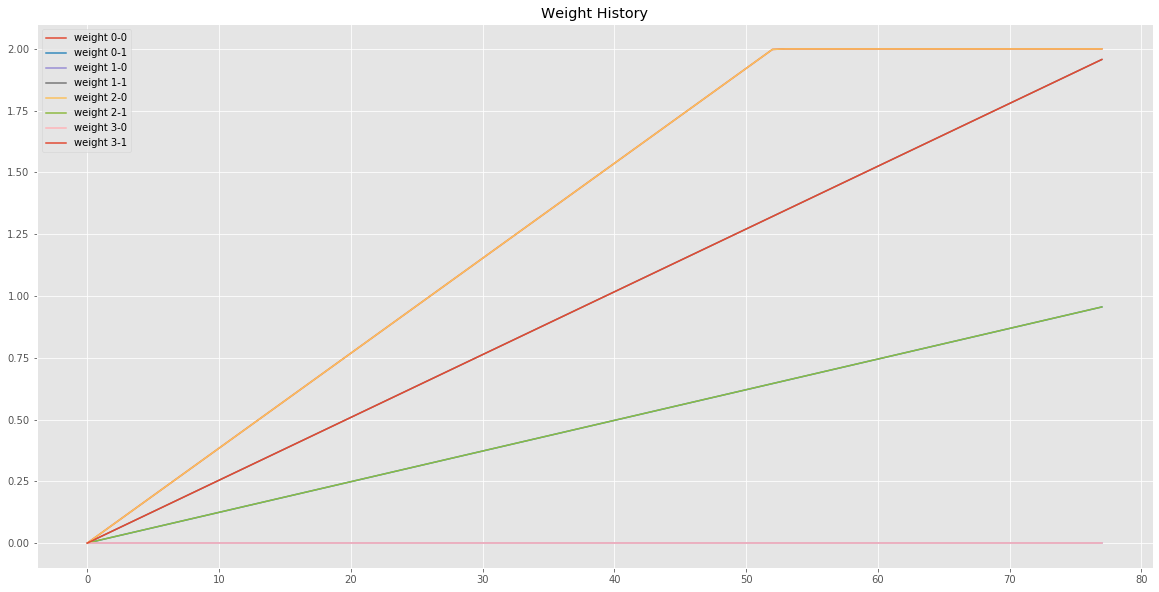

input set: 0
	input 0: 25000.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 25000.0 spikes/1.0s
	input 3: 0.0 spikes/1.0s

	output 0: 150.0 spikes/1.0s, confidence: 0.75
	output 1: 50.0 spikes/1.0s, confidence: 0.25

input set: 1
	input 0: 25000.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 0.0 spikes/1.0s
	input 3: 25000.0 spikes/1.0s

	output 0: 50.0 spikes/1.0s, confidence: 0.3333333333333333
	output 1: 100.0 spikes/1.0s, confidence: 0.6666666666666666

input set: 2
	input 0: 0.0 spikes/1.0s
	input 1: 25000.0 spikes/1.0s
	input 2: 25000.0 spikes/1.0s
	input 3: 0.0 spikes/1.0s

	output 0: 50.0 spikes/1.0s, confidence: 0.3333333333333333
	output 1: 100.0 spikes/1.0s, confidence: 0.6666666666666666

input set: 3
	input 0: 0.0 spikes/1.0s
	input 1: 25000.0 spikes/1.0s
	input 2: 0.0 spikes/1.0s
	input 3: 25000.0 spikes/1.0s

	output 0: 0.0 spikes/1.0s, confidence: 0.0
	output 1: 150.0 spikes/1.0s, confidence: 1.0



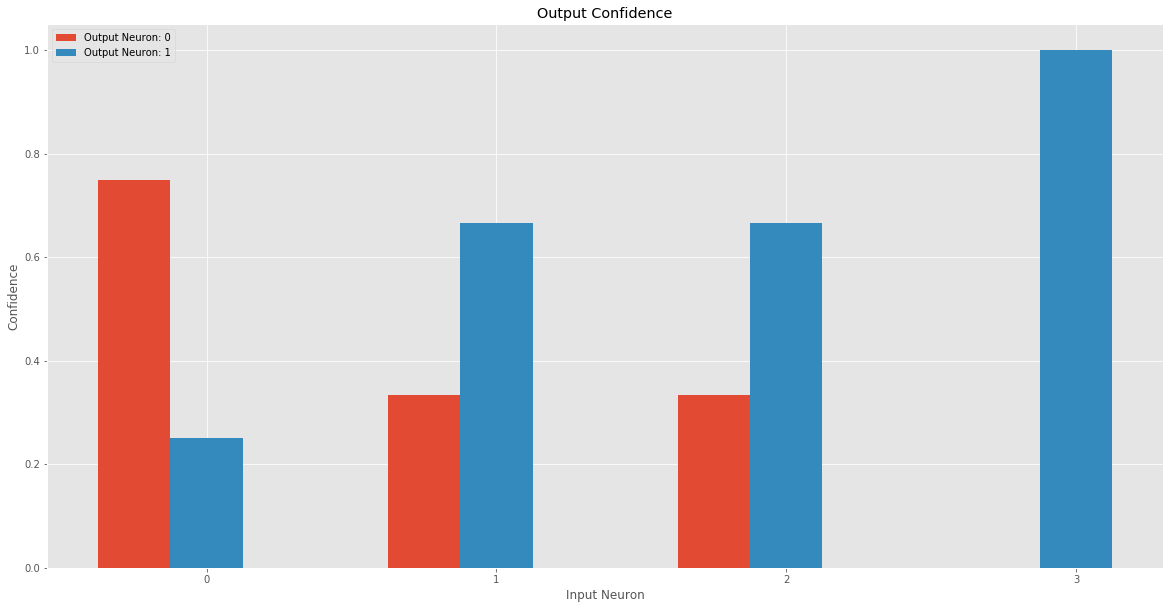

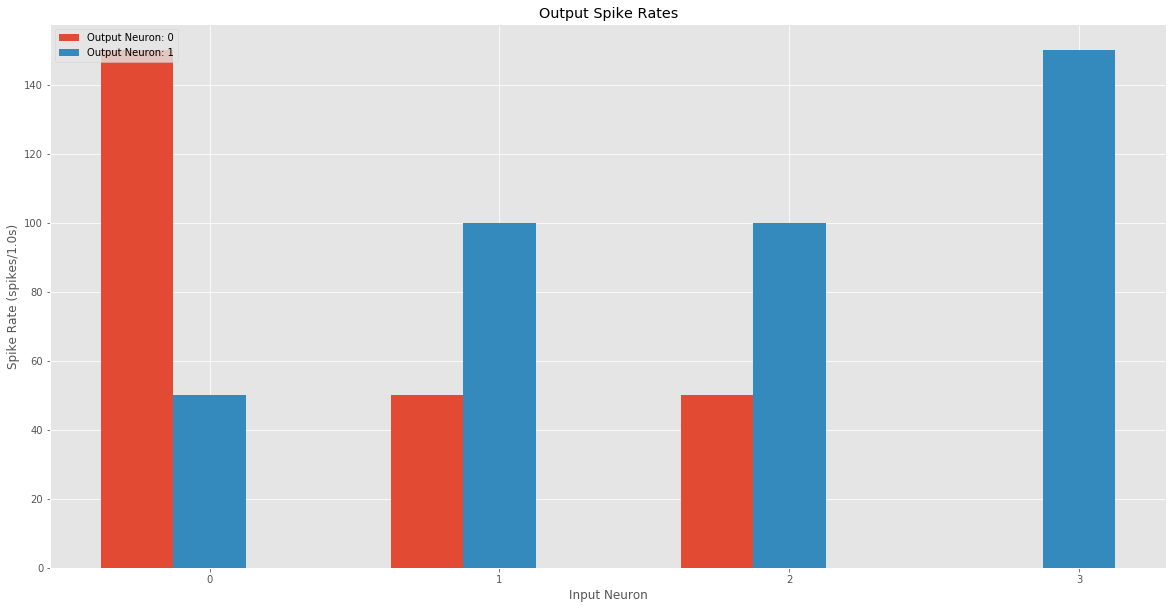

In [4]:
u_t = 2000  # units of time
i_a = 1000.0  # input amount

# NOTE: we want the same number of training inputs for each output class
inputs = np.array(
    [
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: T, y: F --> F
        [[0.0] * u_t, [i_a] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: F, y: T --> F
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F
    ]
)

t_a = 1000.0  # training amount
s_a = -100.0  # supress amount

# current that gets injected to the output neurons
trainings = np.array(
    [
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
    ]
)

# initiate the weights to be half of max weight
weights = np.array(
    [
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
    ]
)

and_network = SingleLayerSNN(inputs=inputs, weights=weights, trainings=trainings)

# BEST PARAMS FOR AND NETWORK: epochs=77, a_corr=0.000000002, w_max=2.0, w_decay=0.0001
and_network.train(epochs=77, a_corr=0.000000002, w_max=2.0, w_decay=0.0001)

p_a = 10000.0  # predict input amount

# the four possible cases
predict_inputs = np.array(
    [
        [[p_a] * u_t, [0.0] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[p_a] * u_t, [0.0] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: T, y: F --> F
        [[0.0] * u_t, [p_a] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: F, y: T --> F
        [[0.0] * u_t, [p_a] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: F, y: F --> F
    ]
)
and_network.predict(predict_inputs)

# and_network.voltage_to_spike_rate([80, 80, 80, 80, 80, 0, 0, 0, 0, 0, 80, 80], dT=0.01, rate=1)


In [5]:
a = np.array([1, 2, 3, 4])
b = np.array([1, 2])
b = np.pad(b, (0, len(a) - len(b)), "constant")
c = [2, 3, 5]

shuffled, order = shuffle_forward(a)
print('shuffled:', shuffled)
unshuffled = shuffle_backward(shuffled, order)
print('unshuffled:', unshuffled)


shuffled: [1 2 4 3]
unshuffled: [1, 2, 3, 4]
